In [2]:
import requests
import json
from sklearn.cluster import KMeans
import umap
import numpy as np
import requests
import matplotlib.pyplot as plt

In [3]:
cluster_names = ["Trans. Big Man", "Moreyball 3pt spec", "Midrange", "Trad. Big Man", "Moreyball paint spec"]

In [4]:
def get_stats_from_scid(typeof, scid):
    playerid, year = scid.split('-')
    filename = typeof+'/'+year+'.json'
    loaded = json.loads(open(filename).read())
    headers = loaded['resultSets'][0]['headers']
    for player in loaded['resultSets'][0]['rowSet']:
        if str(player[0]) == (playerid):
            player_data = player
    player_data = dict(zip(headers, player_data))
    return player_data

In [5]:
locations = {
    "Mid-Range": ['L', 'R', 'C', 'RC', 'LC'], 
    "Above the Break 3": ['C', 'RC', 'LC'], 
    "Restricted Area": ['C'], 
    "Corner 3": ['R', 'L'], 
    "In The Paint (Non-RA)": ['R', 'L','C']
}

In [6]:
from matplotlib.patches import Circle, Rectangle, Arc
#written by http://savvastjortjoglou.com/nba-shot-sharts.html
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [7]:
def get_model(shots, n_clusters=5):
    
    shot_charts = {}
    shot_chart_raw = {}
    
    for shot in shots:
        day = shot[-3]
        first_part = day[2:4]
        int_year = int(day[2:4])
        
        if int_year == 0:
            int_year = 100
            
        second_part = str(int_year-1)[-2:]
        if len(second_part) == 1:
            second_part = "0"+second_part
        overall = second_part+first_part
        if day[4] == '1':
            second_part = str(int_year+1)[-2:]
            if len(second_part) == 1:
                second_part = "0"+second_part
            overall = first_part+second_part
        
            
        shot_chart_id = str(shot[3])+'-'+overall
        made = 0
        if 'Made' in shot[10]:
            made = 1
        if shot_chart_id in shot_charts:
            shot_charts[shot_chart_id].append([shot[13], shot[14], made])
            shot_chart_raw[shot_chart_id].append(np.array([int(shot[17]), int(shot[18])]))
        else:
            shot_charts[shot_chart_id] = [[shot[13], shot[14], made]]
            shot_chart_raw[shot_chart_id] = [np.array([int(shot[17]), int(shot[18])])]
            
    before_umap_shot_chart_data = []
    for key in list(shot_charts.keys()):
        current_number = 0
        fgm_fga_per_loc = np.zeros([14,2])
        freq_fgp_per_loc = np.zeros([14,1])
        for location_large in (list(locations.keys())):
            for location_small in (list(locations[location_large])):
                for shot in shot_charts[key]:
                    if location_large in shot[0] and location_small in shot[1]:
                        fgm_fga_per_loc[current_number][1] += 1
                        if shot[2] == 1:
                            fgm_fga_per_loc[current_number][0] += 1
                current_number += 1

        for idx, loc in enumerate(fgm_fga_per_loc):
            if np.sum(fgm_fga_per_loc[:,1]) > 0:
                freq_fgp_per_loc[idx][0] = (loc[1])/(np.sum(fgm_fga_per_loc[:,1]))

        before_umap_shot_chart_data.append(freq_fgp_per_loc.flatten())
        
    kmeans = KMeans(n_clusters=n_clusters, random_state=2000).fit(before_umap_shot_chart_data)
    predictions = kmeans.predict(before_umap_shot_chart_data)
    
    return kmeans, predictions, shot_chart_raw, before_umap_shot_chart_data

In [16]:
def get_plots(kmeans, predictions, shot_chart_raw, before_umap_shot_chart_data, n_clusters=5, nshotcharts=5):
    x = [str(thing) for thing in cluster_names]
    corresponding_numbers = [len(np.where(predictions == cluster)[0]) for cluster in range(0,5)]    
    plt.bar(x, corresponding_numbers, align='center', alpha=0.5)
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
    
    for clusteri in range(n_clusters):
        print(clusteri)
        
        indices = np.where(predictions == clusteri)[0]
        np.random.shuffle(indices)
        number_shown = 0
        
        fig = plt.figure(figsize=(12*5,11))
        
        for zero in indices:

            if number_shown == nshotcharts:
                break
                
            chart = np.array(list(shot_chart_raw.values())[zero])
            
            if (chart).shape[0] > 200:
                ax = fig.add_subplot(1, 5, number_shown+1)
                ax.scatter(chart[:,0], chart[:,1], s=10, alpha=0.2)
                draw_court(outer_lines=True, ax=ax)
                ax.set_xlim(-300,300)
                ax.set_ylim(-100,500)
                number_shown += 1
                
        plt.show()
        
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(before_umap_shot_chart_data)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=predictions)
    plt.show()

In [9]:
recent = np.loadtxt("shotchart/recent.csv", delimiter=",", dtype=str)
mid = np.loadtxt("shotchart/mid.csv", delimiter=",", dtype=str)
old = np.loadtxt("shotchart/old.csv", delimiter=",", dtype=str)

In [10]:
import matplotlib.pyplot as plt
def get_cluster_chart(years):
    X = range(2,15)
    Y = []
    for ki in range(2,15):
        kmeans, predictions, shot_chart_raw, before_umap_shot_chart_data = get_model(years, n_clusters=ki)
        Y.append(kmeans.inertia_)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.plot(X, Y)
    plt.show()

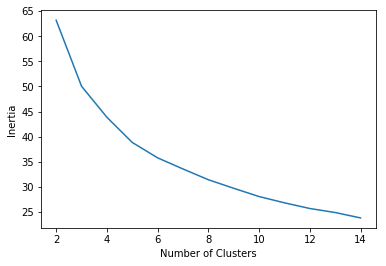

In [11]:
get_cluster_chart(recent)

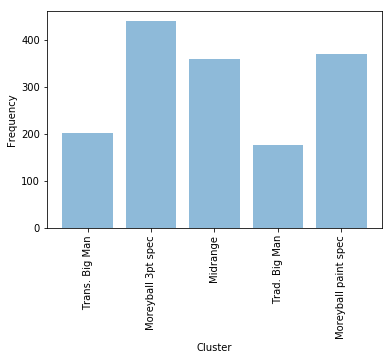

0


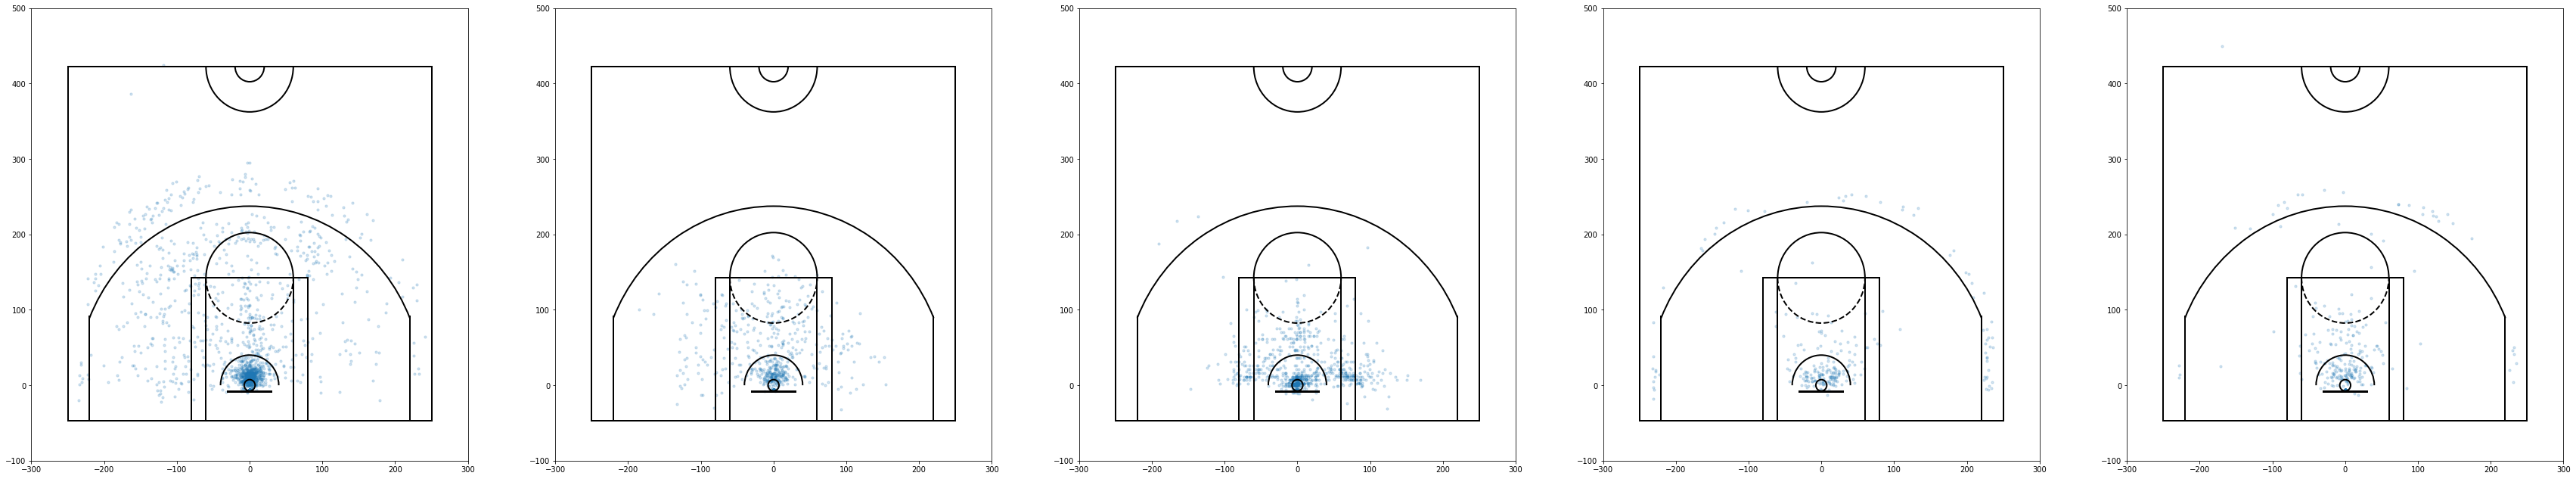

1


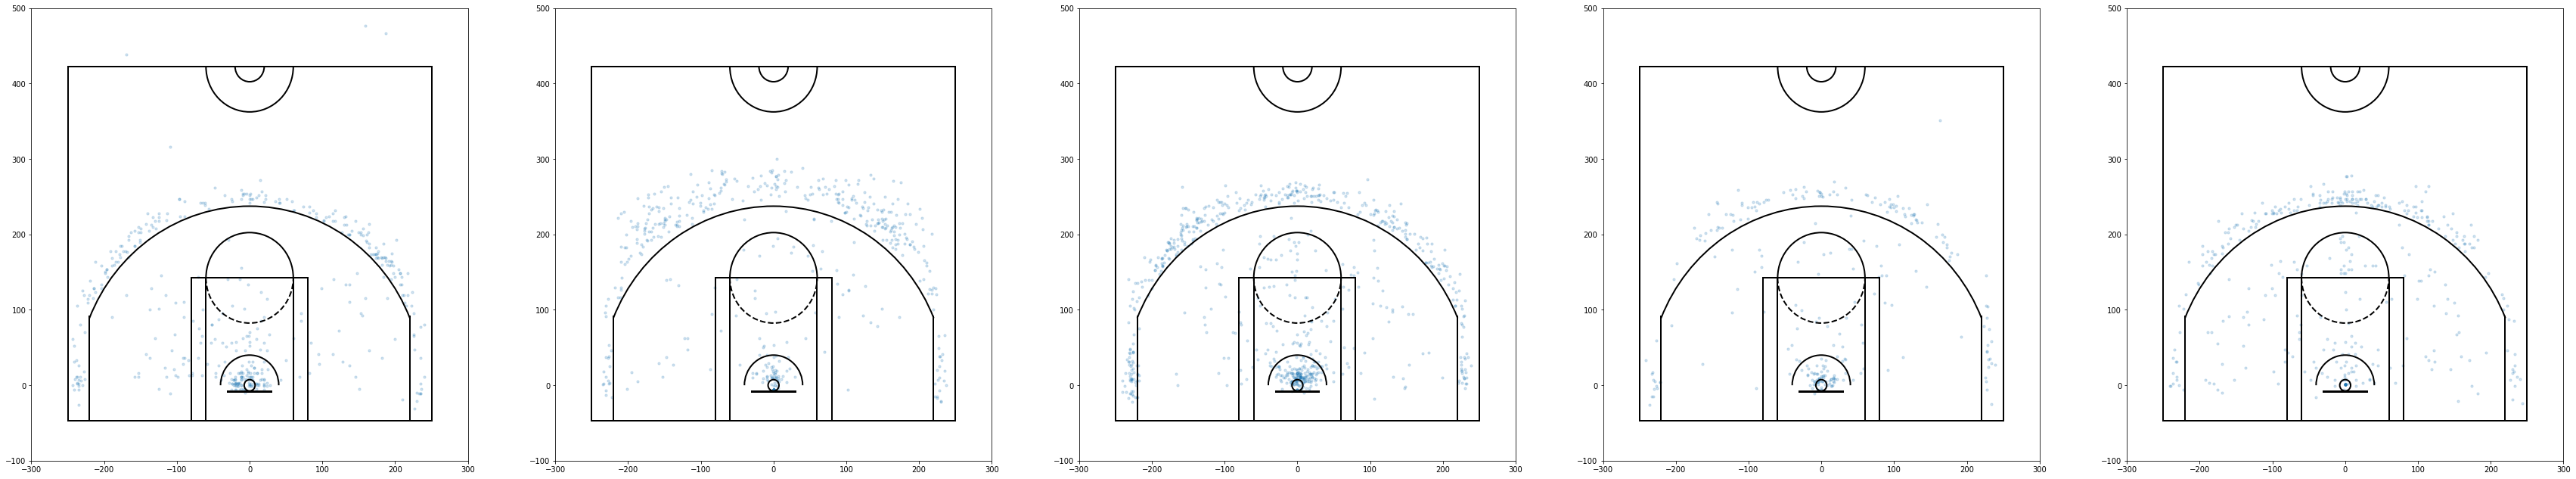

2


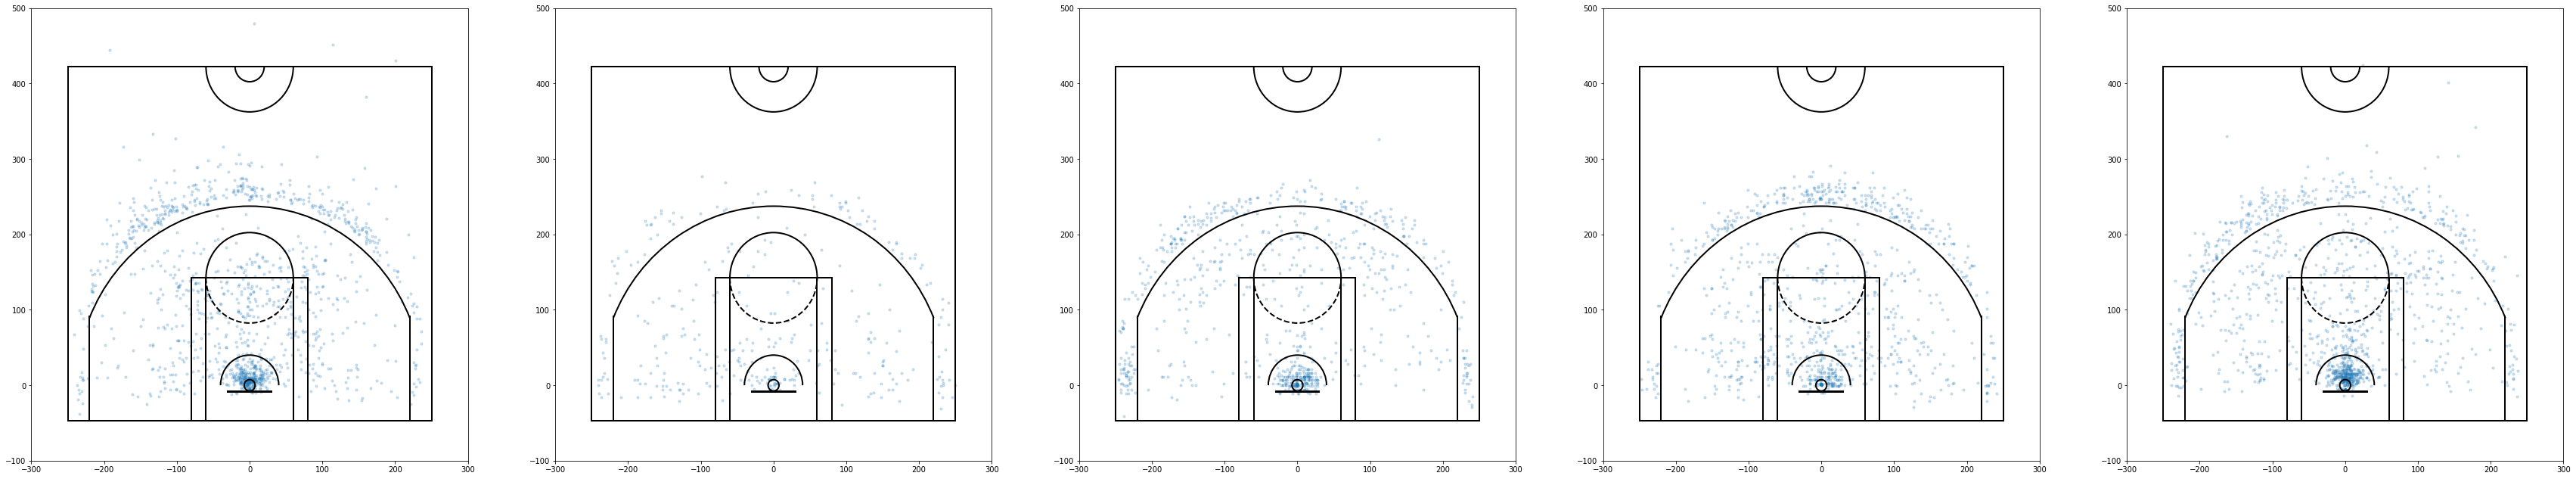

3


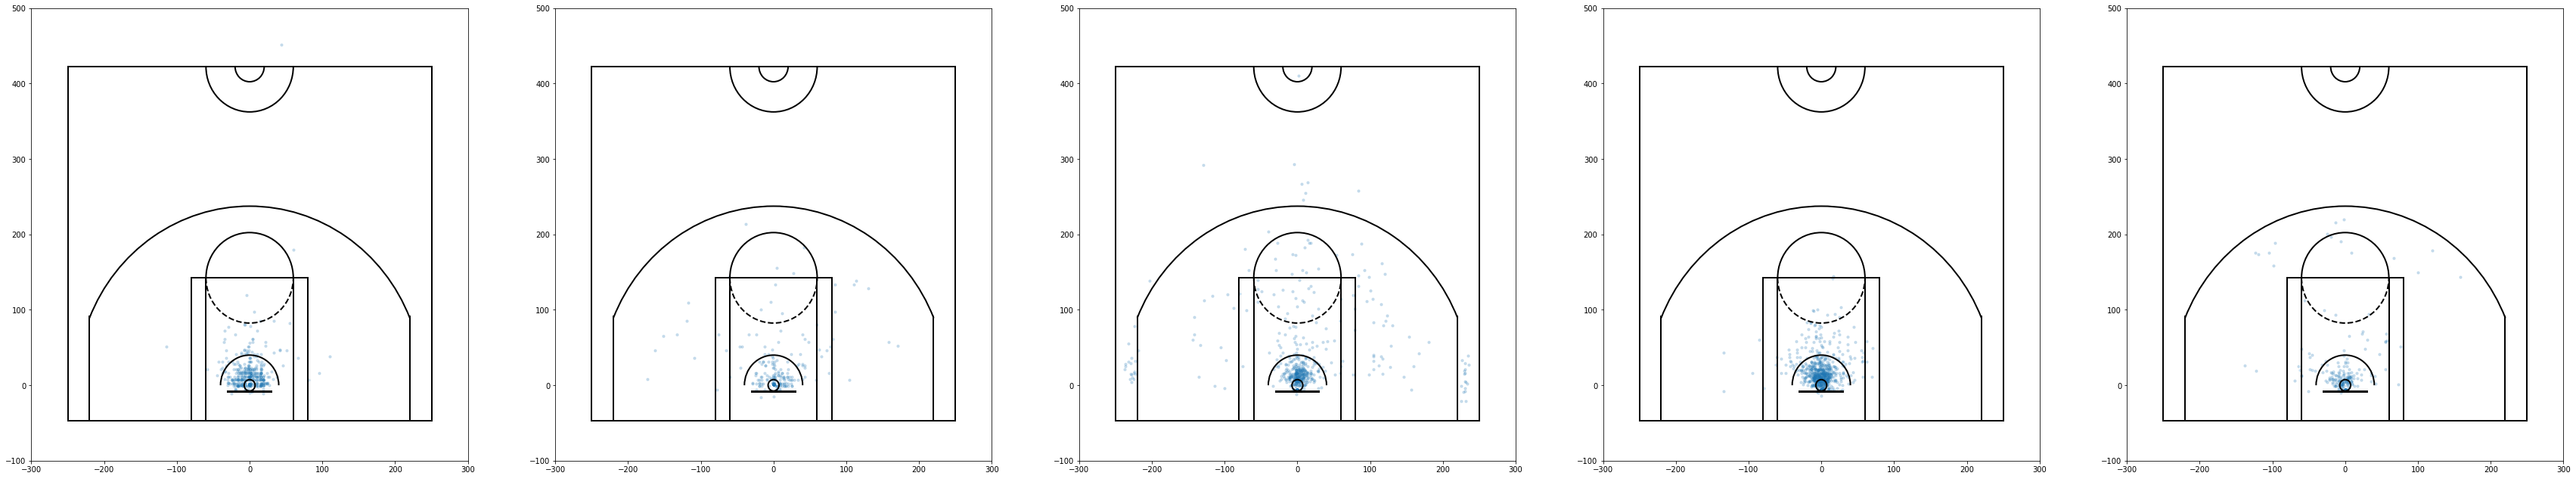

4


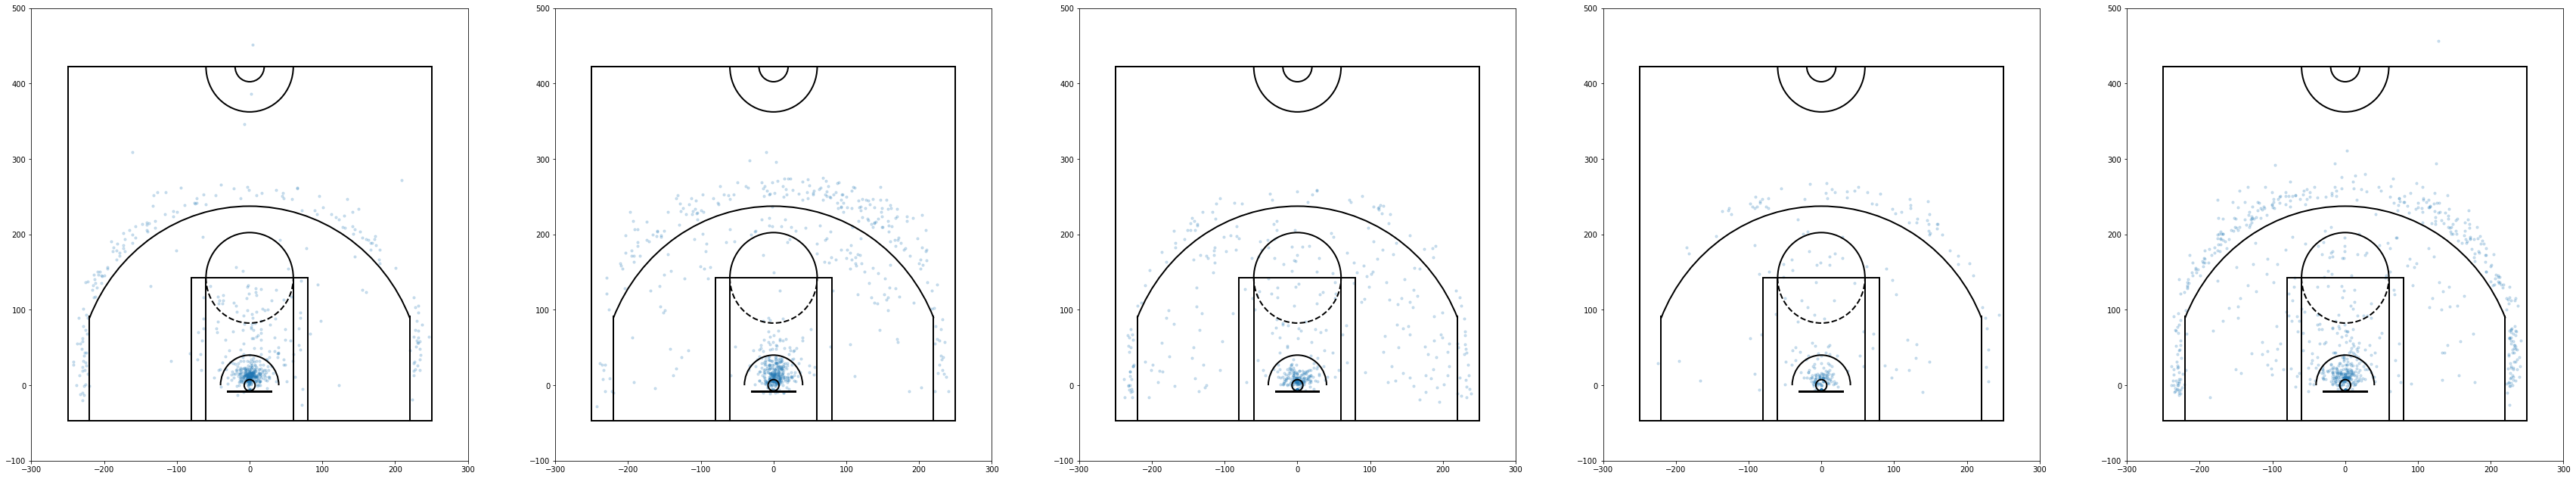

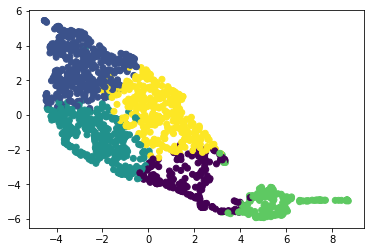

In [17]:
kmeans, predictions, shot_chart_raw, before_umap_shot_chart_data = get_model(recent, n_clusters=5)
get_plots(kmeans, predictions, shot_chart_raw, before_umap_shot_chart_data, n_clusters=5)

In [195]:
def get_distribution_for_team(team, years_cleaned):
    _, _, raw_for_this, before_umap_for_this = get_model(years_cleaned, n_clusters=5)
    predictions_for_this = kmeans.predict(before_umap_for_this)
    player_to_prediction = dict(zip(list(raw_for_this.keys()), predictions_for_this))
    number_per_cluster = [0,0,0,0,0]
    for season in list(player_to_prediction.keys()):
        advanced = get_stats_from_scid('advanced', season)
        base = get_stats_from_scid('base', season)
        if base['TEAM_ABBREVIATION'] == team:
            number_per_cluster[player_to_prediction[season]] += 1

    who = [str(thing) for thing in cluster_names]
    plt.bar(who, number_per_cluster, align='center', alpha=0.5)
    plt.ylim([0,35])
    plt.title(team+' Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

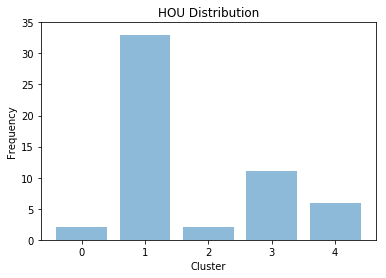

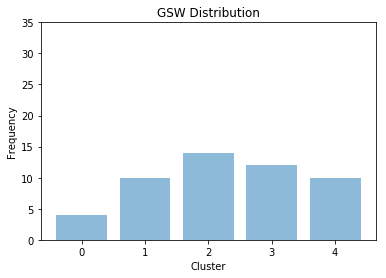

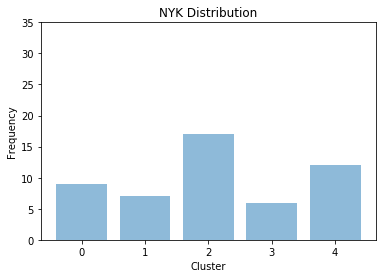

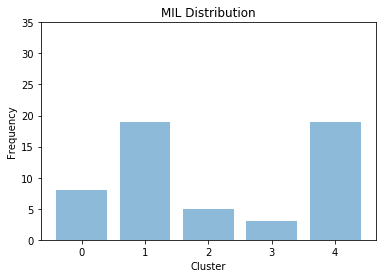

In [175]:
get_distribution_for_team('HOU', recent)
get_distribution_for_team('GSW', recent)
get_distribution_for_team('NYK', recent)
get_distribution_for_team('MIL', recent)

In [183]:
def get_players_from_each_cluster(years_cleaned):
    _, _, raw_for_this, before_umap_for_this = get_model(years_cleaned, n_clusters=5)
    predictions_for_this = kmeans.predict(before_umap_for_this)
    player_to_prediction = dict(zip(list(raw_for_this.keys()), predictions_for_this))
    players_per_cluster = [[],[],[],[],[]]
    for season in list(player_to_prediction.keys()):
        base = get_stats_from_scid('base', season)
        name = base['PLAYER_NAME']
        players_per_cluster[player_to_prediction[season]].append(name)
    return players_per_cluster

In [19]:
def get_plots_using_new_clusters(years):
    _, _, raw, before_umap = get_model(years, n_clusters=5)
    predictions = kmeans.predict(before_umap)
    get_plots(kmeans, predictions, raw, before_umap,nshotcharts=5)

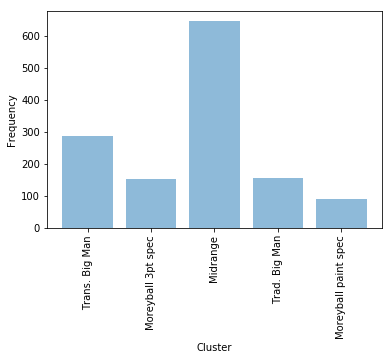

0


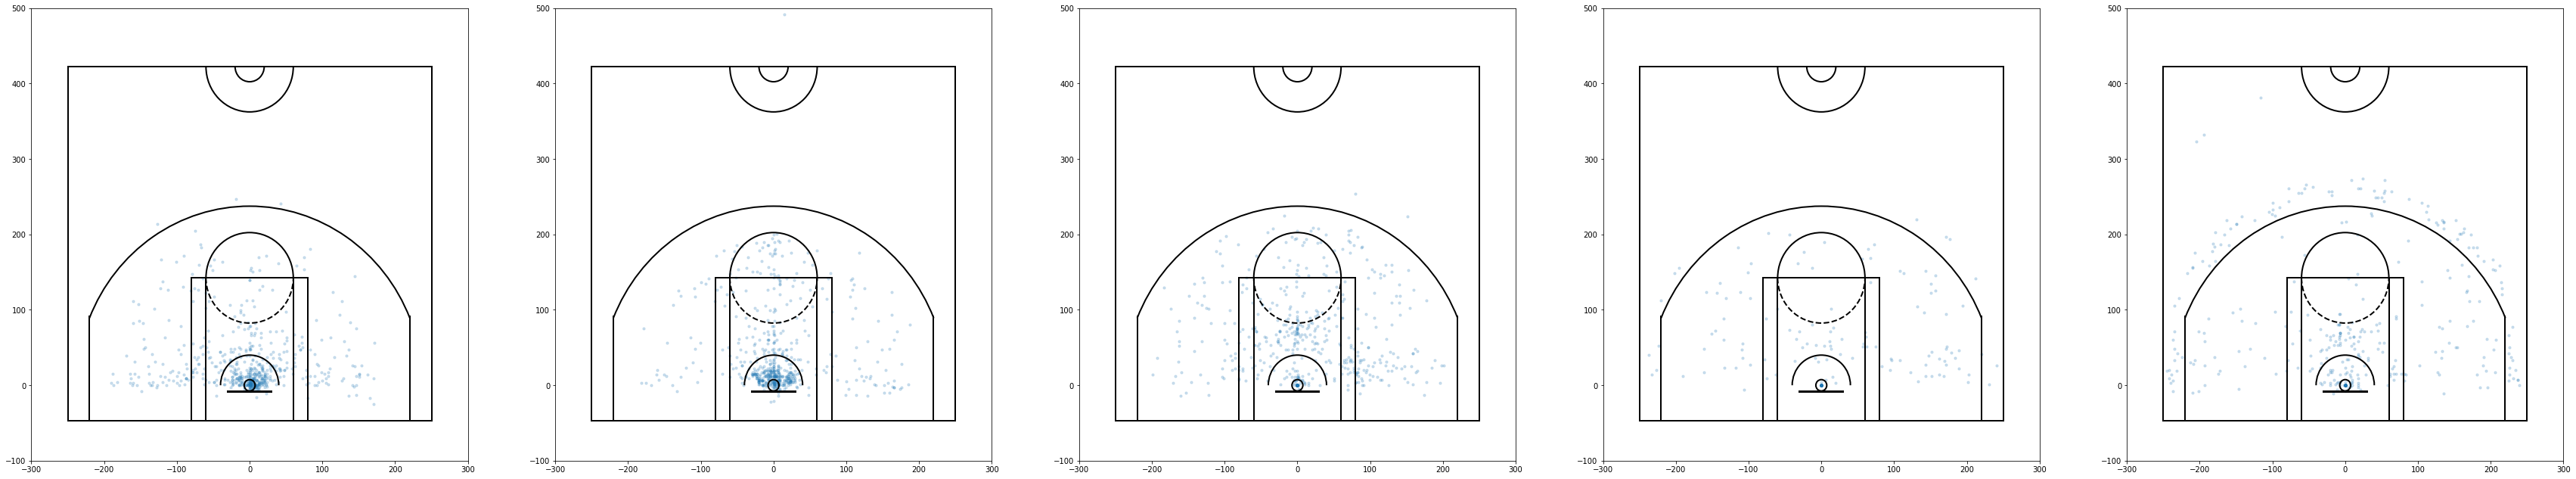

1


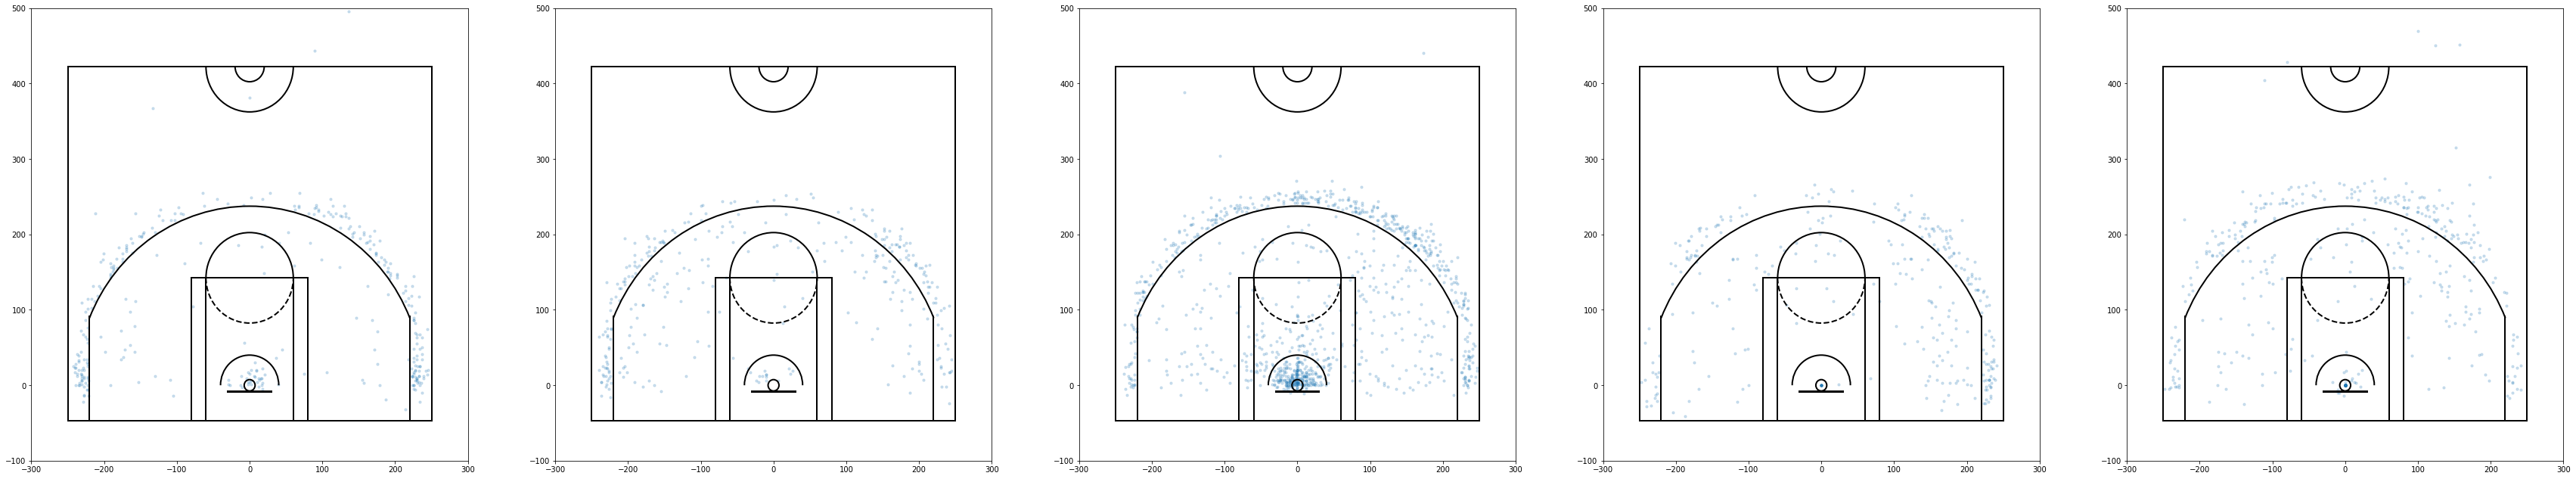

2


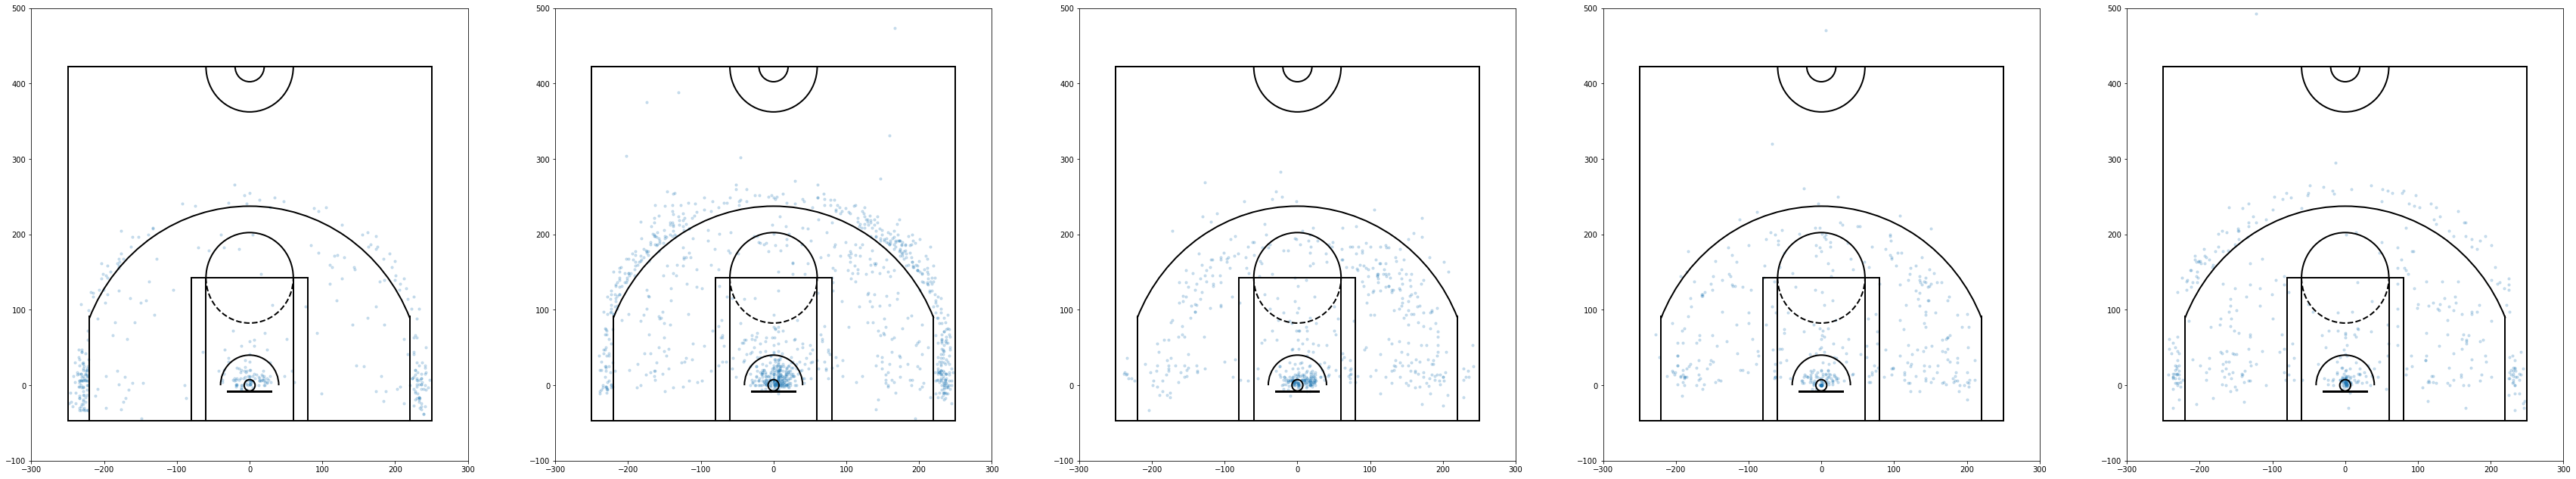

3


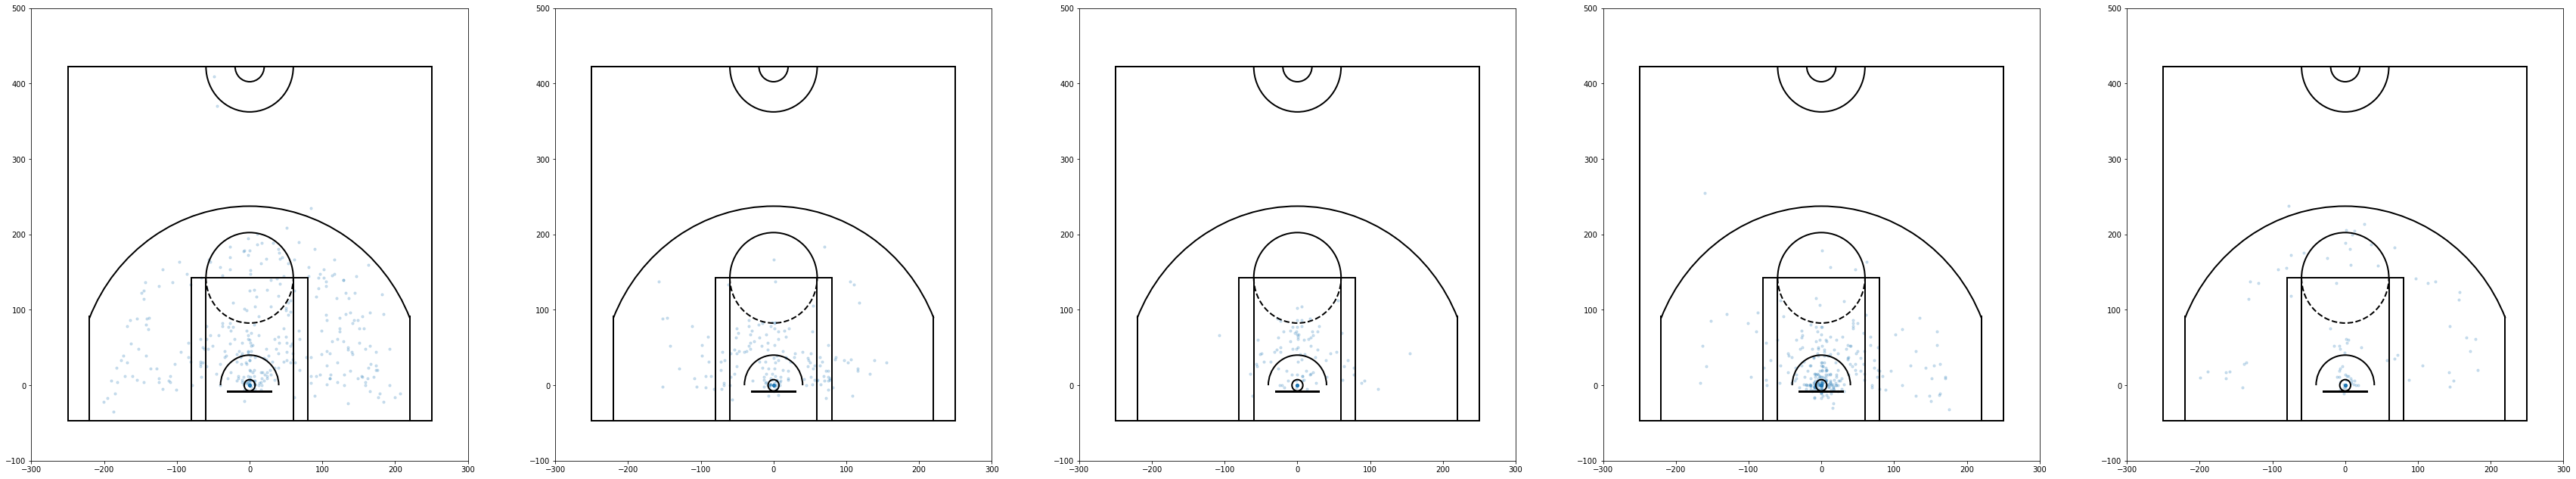

4


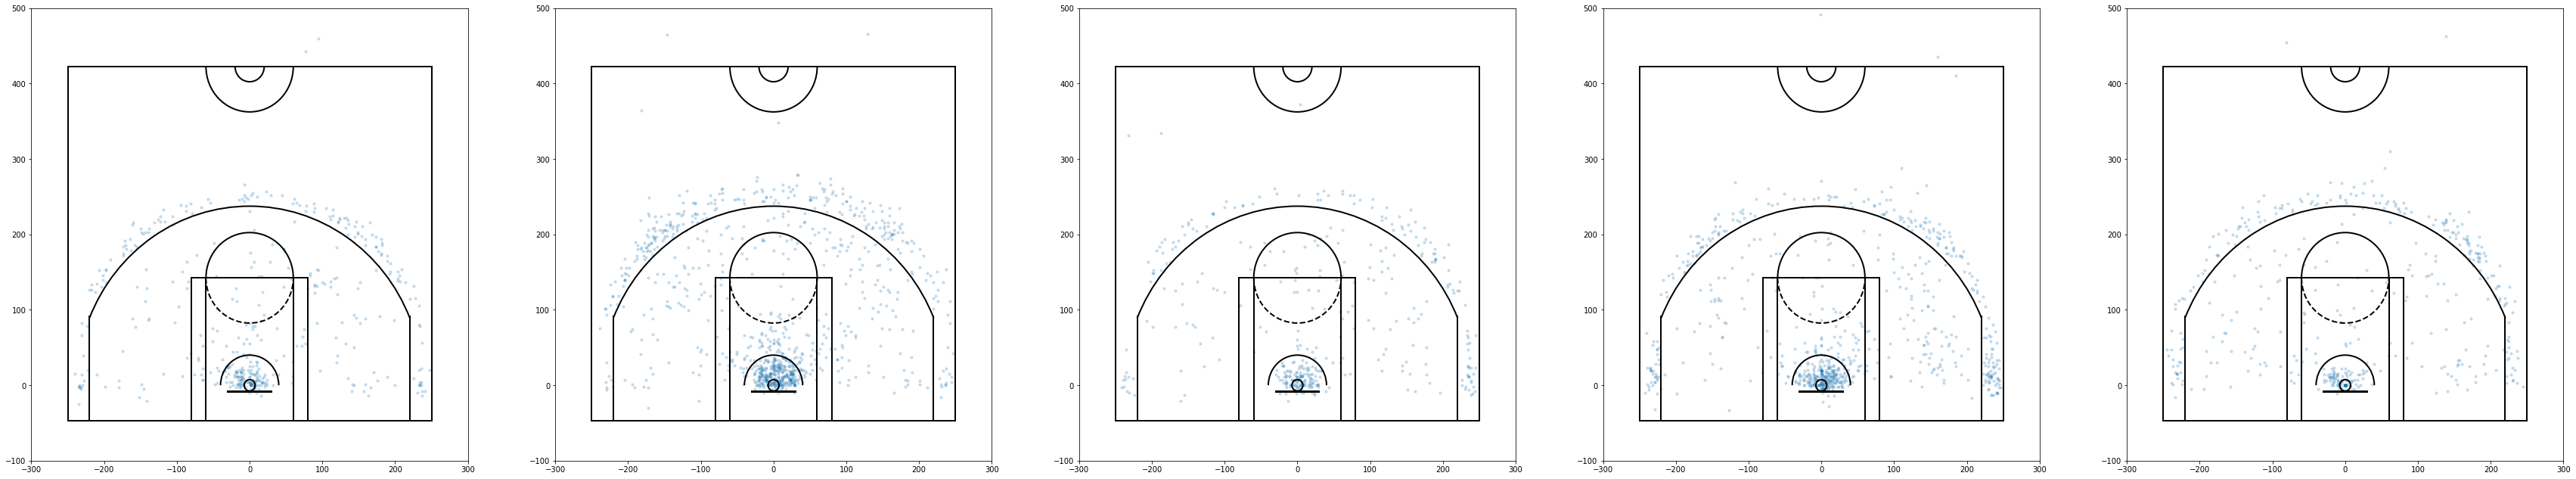

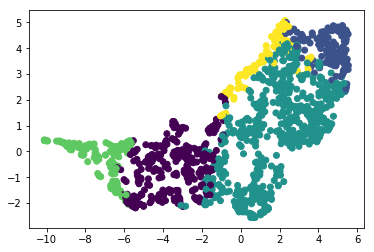

In [20]:
get_plots_using_new_clusters(mid)

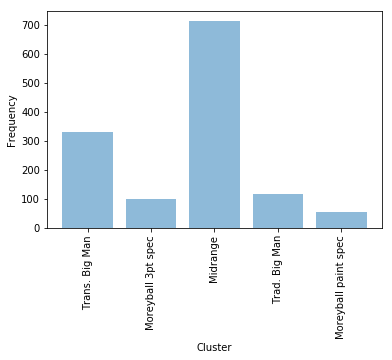

0


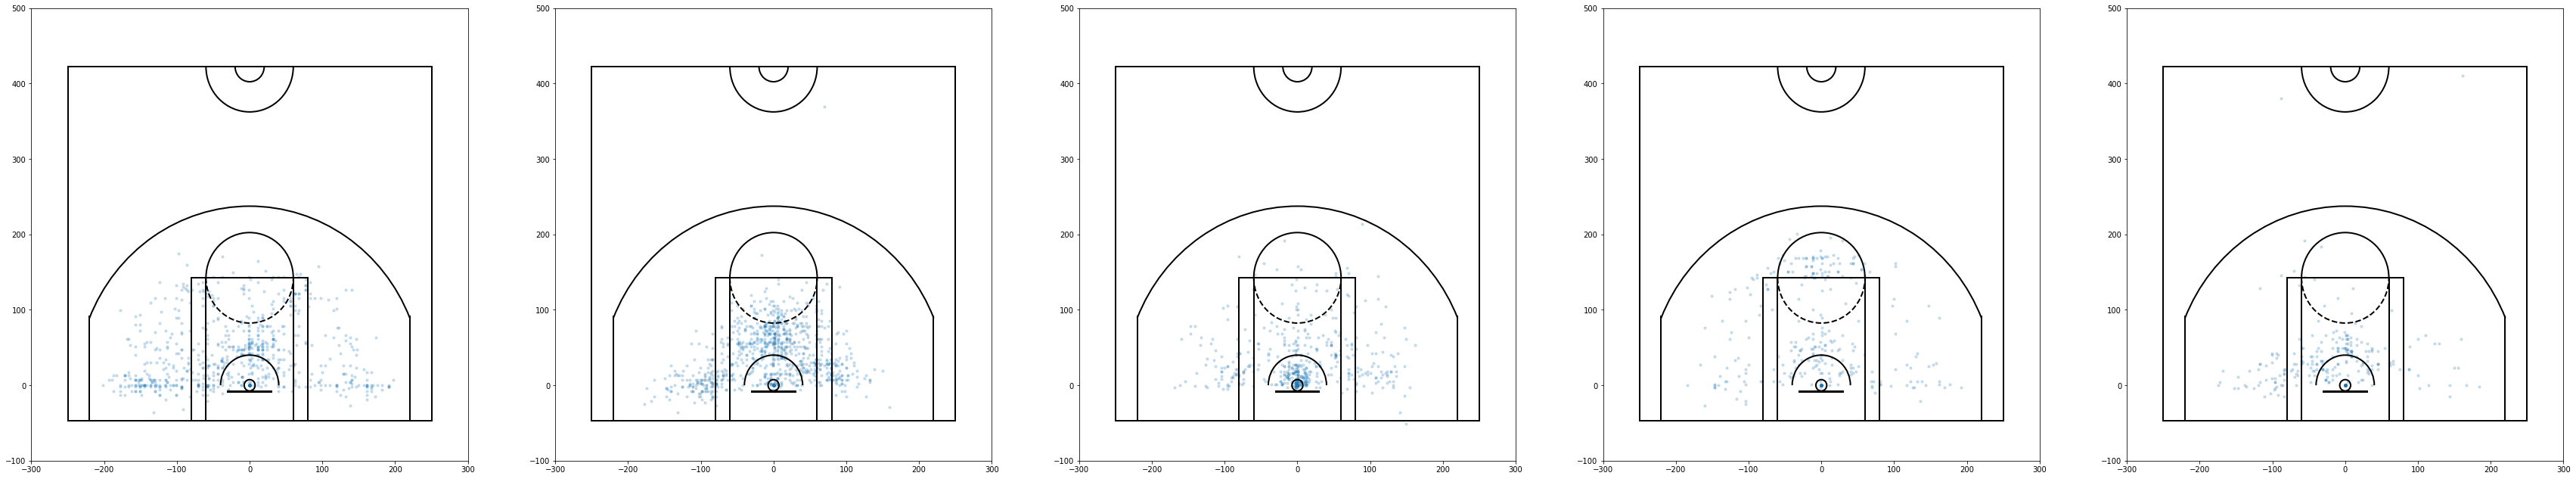

1


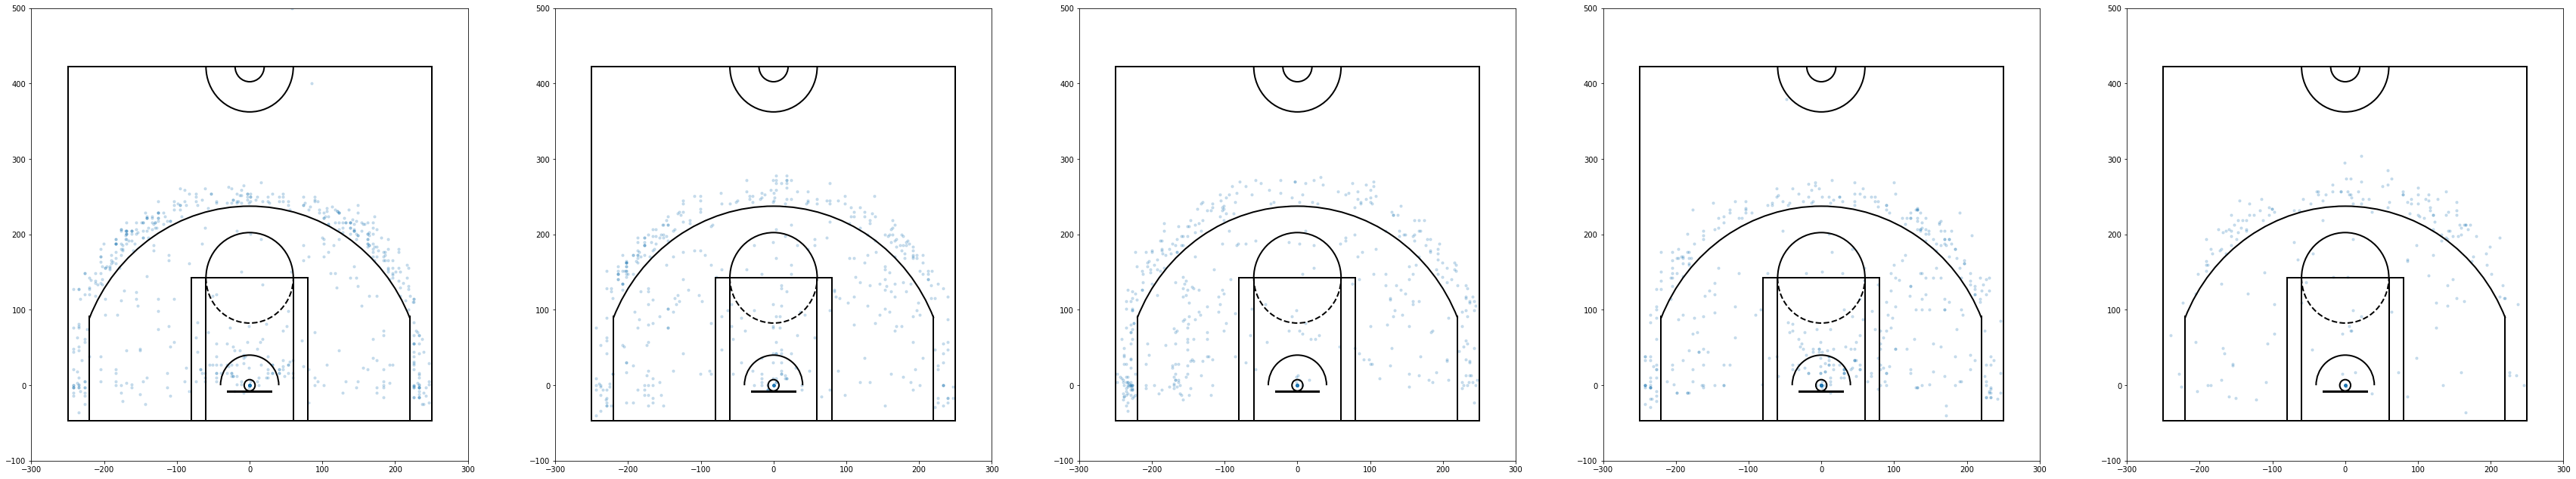

2


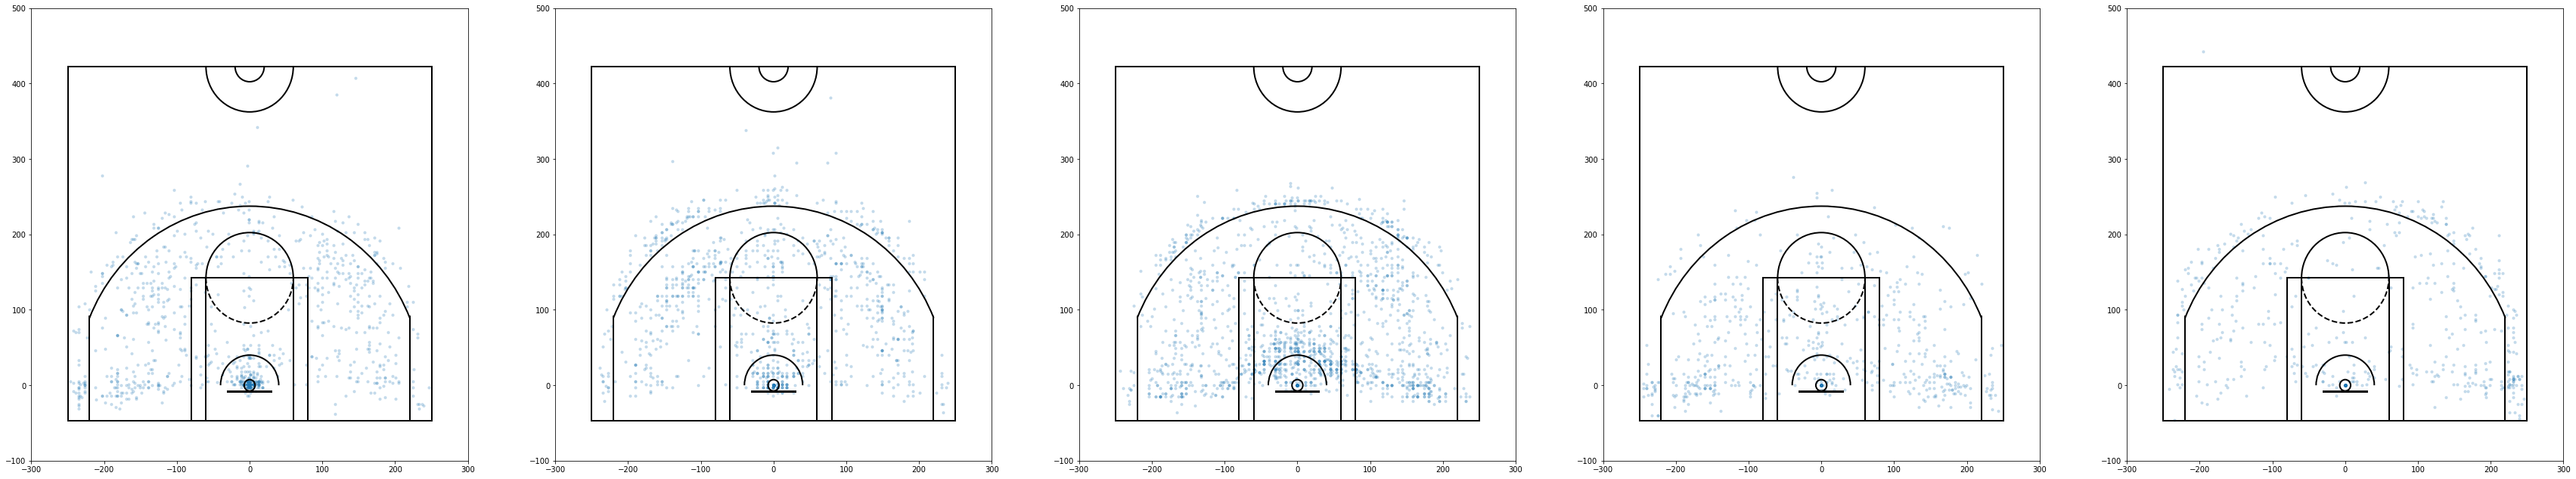

3


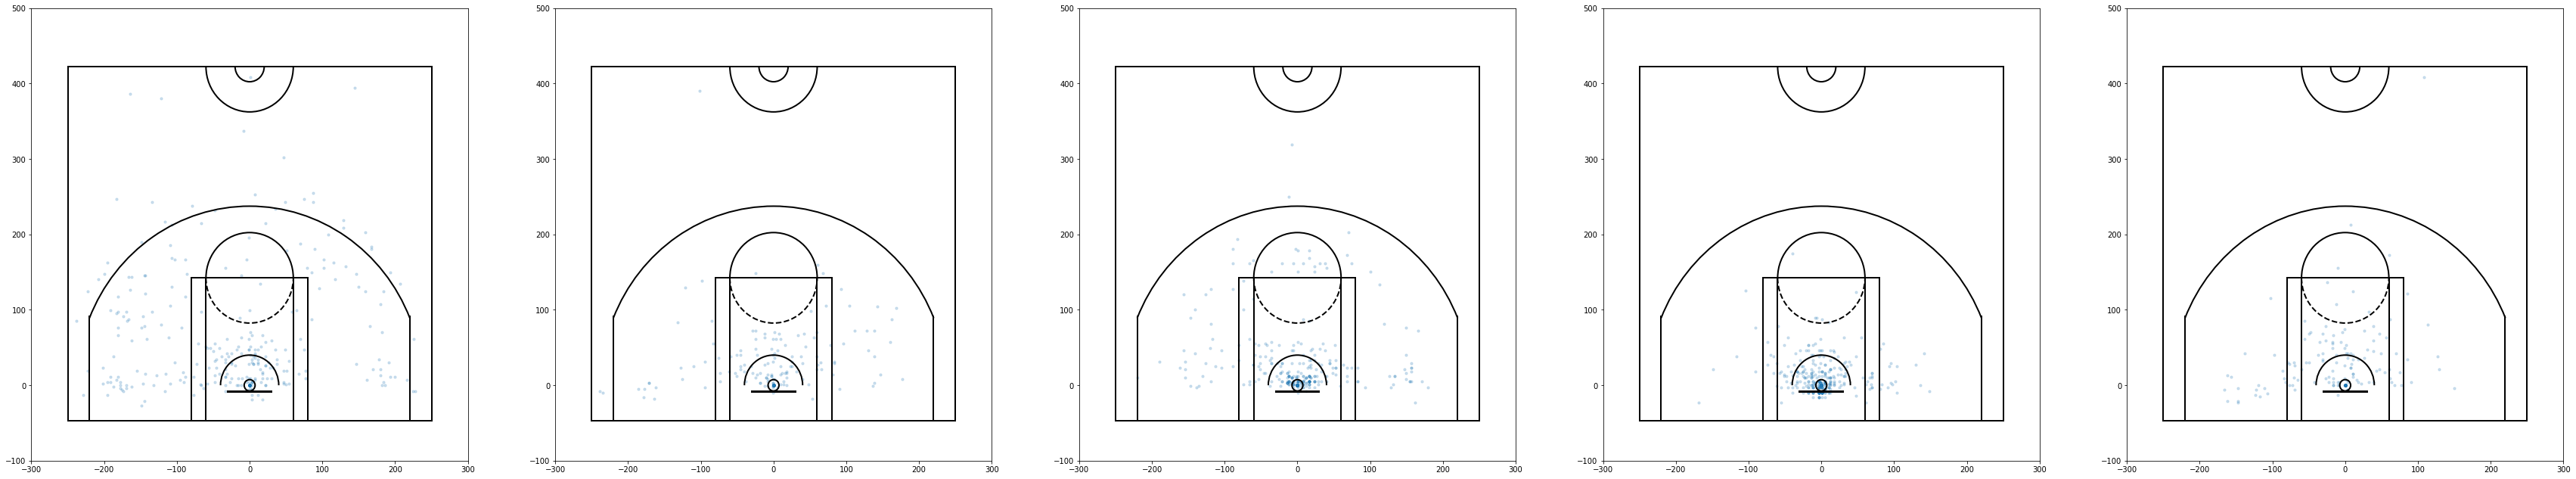

4


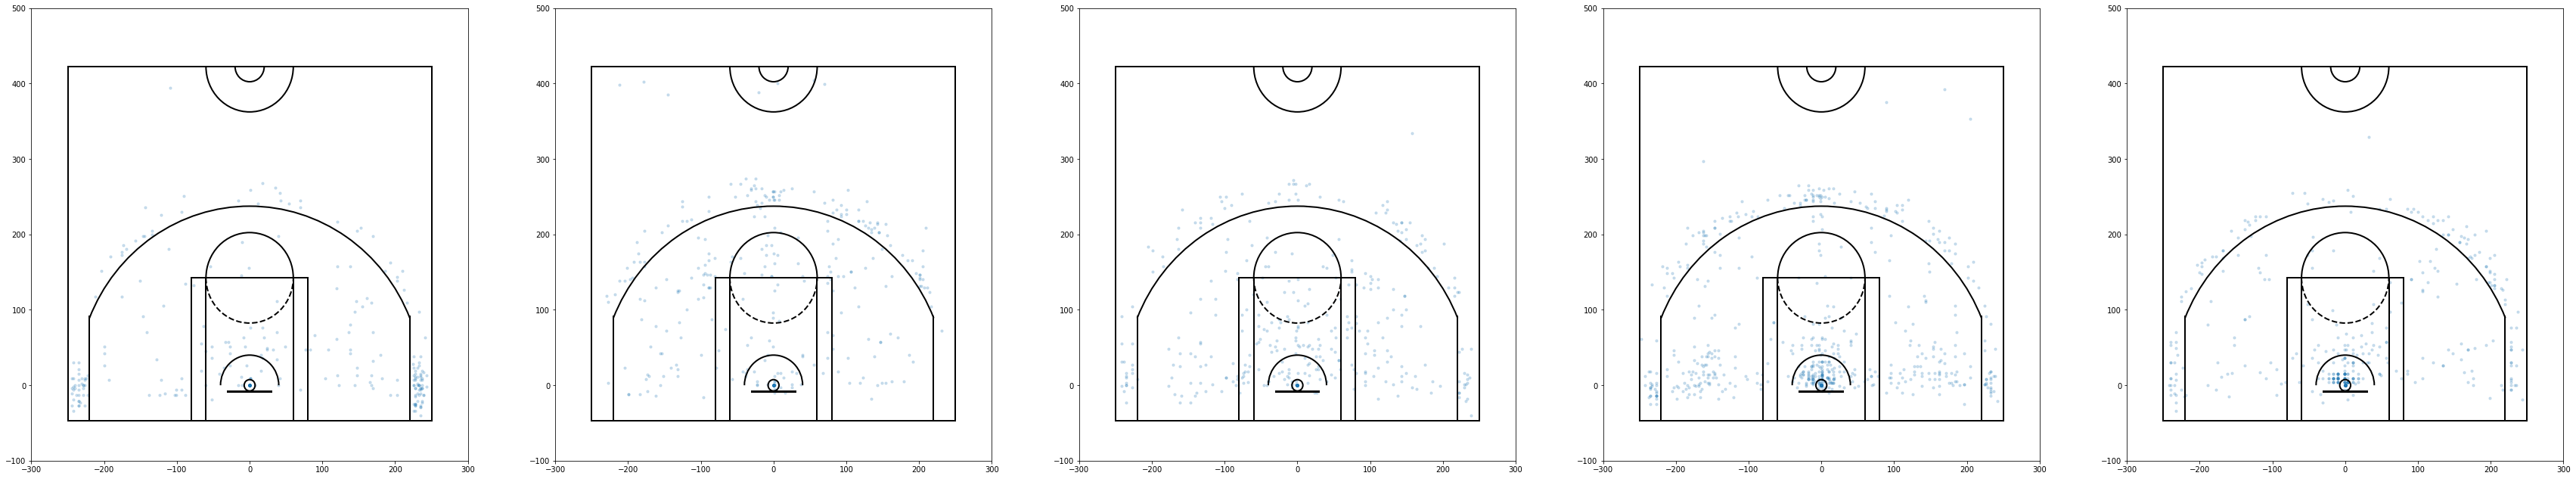

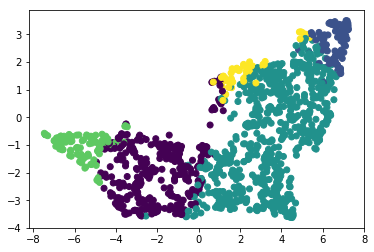

In [21]:
get_plots_using_new_clusters(old)

In [24]:
def cross_reference_stat(typeof, stat, years_cleaned, title):
    _, _, raw_for_this, before_umap_for_this = get_model(years_cleaned, n_clusters=5)
    predictions_for_this = kmeans.predict(before_umap_for_this)
    player_to_prediction = dict(zip(list(raw_for_this.keys()), predictions_for_this))
    number_per_cluster = [[],[],[],[],[]]
    for season in list(player_to_prediction.keys()):
        base = get_stats_from_scid(typeof, season)
        mins = base[stat]
        number_per_cluster[player_to_prediction[season]].append(mins)
    averages_per_cluster = []
    for arr in (number_per_cluster):
        averages_per_cluster.append(np.mean(np.array(arr)))
    x = [str(thing) for thing in range(0,5)]    
    plt.bar(x, averages_per_cluster, align='center', alpha=0.5)
    plt.title('Cluster vs '+stat+' '+title)
#     plt.xticks(rotation=90)
    plt.ylim([0, 0.7])
    plt.show()

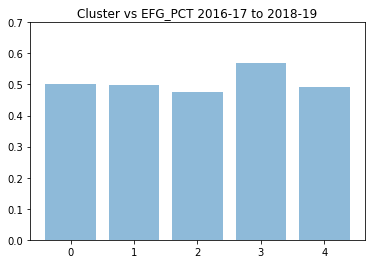

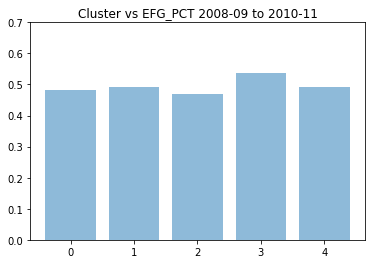

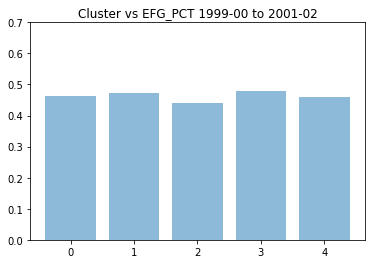

In [25]:
"""
Cluster 0 - Transitioning Big Men
Cluster 1 - Moreyball 3 Point Specialists
Cluster 2 - Midrange Players
Cluster 3 - Traditional Big Men
Cluster 4 - Moreyball Paint Specialist
"""
cross_reference_stat('advanced','EFG_PCT', recent, "2016-17 to 2018-19")
cross_reference_stat('advanced','EFG_PCT', mid, "2008-09 to 2010-11")
cross_reference_stat('advanced','EFG_PCT', old, "1999-00 to 2001-02")
# cross_reference_stat('advanced','USG_PCT', rn)
# cross_reference_stat('base','MIN', rn)
# cross_reference_stat('base','FG3_PCT', rn)

In [172]:
rn = np.loadtxt("shotchart/uptilldec22.csv", delimiter=",", dtype=str)

457


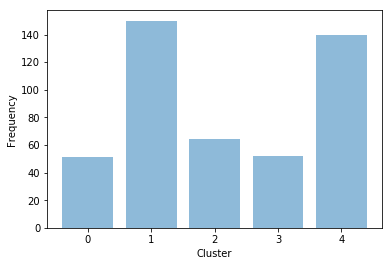

0


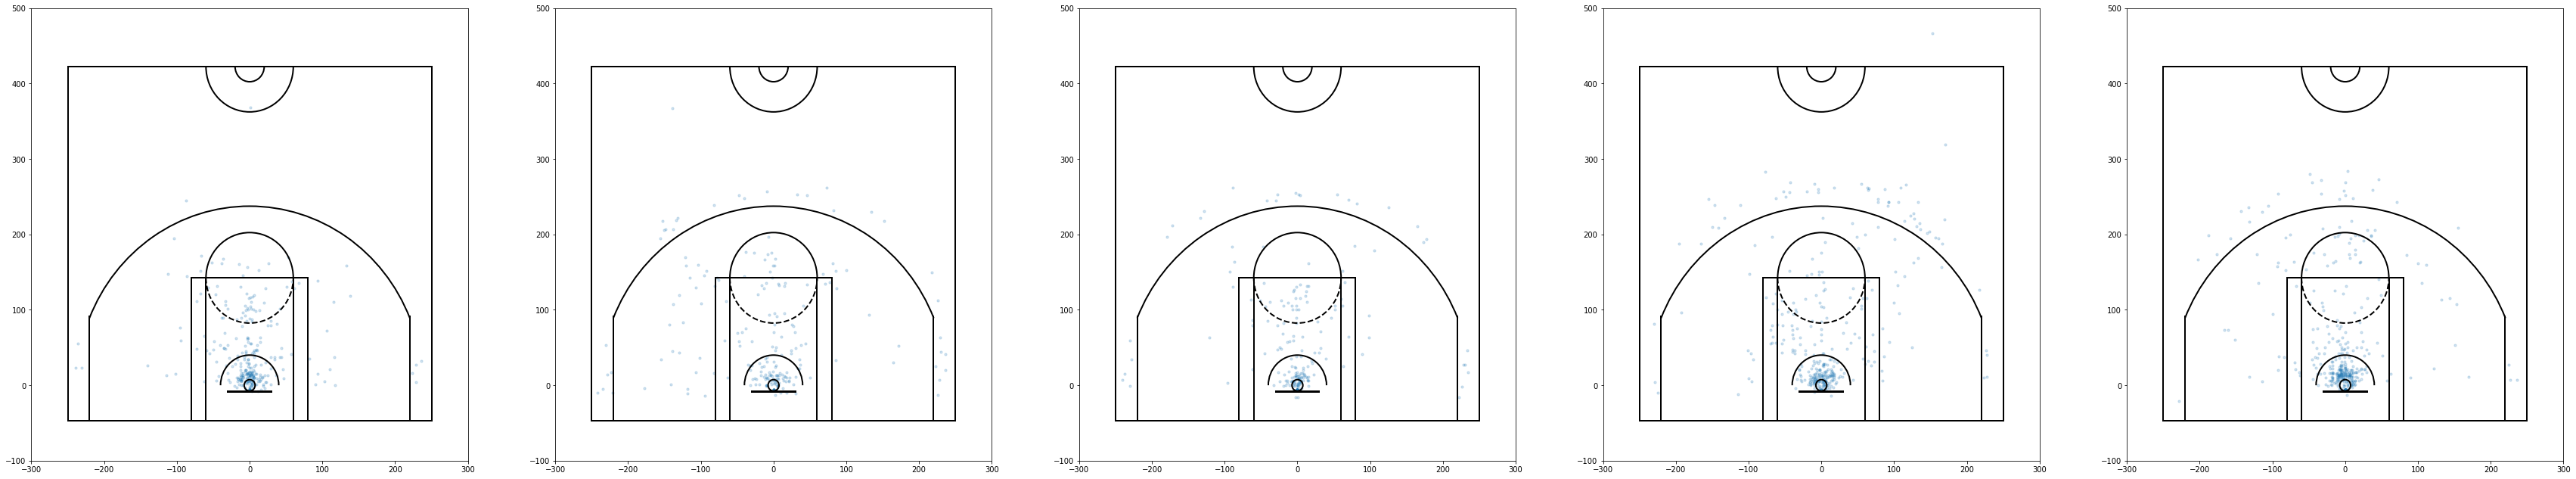

1


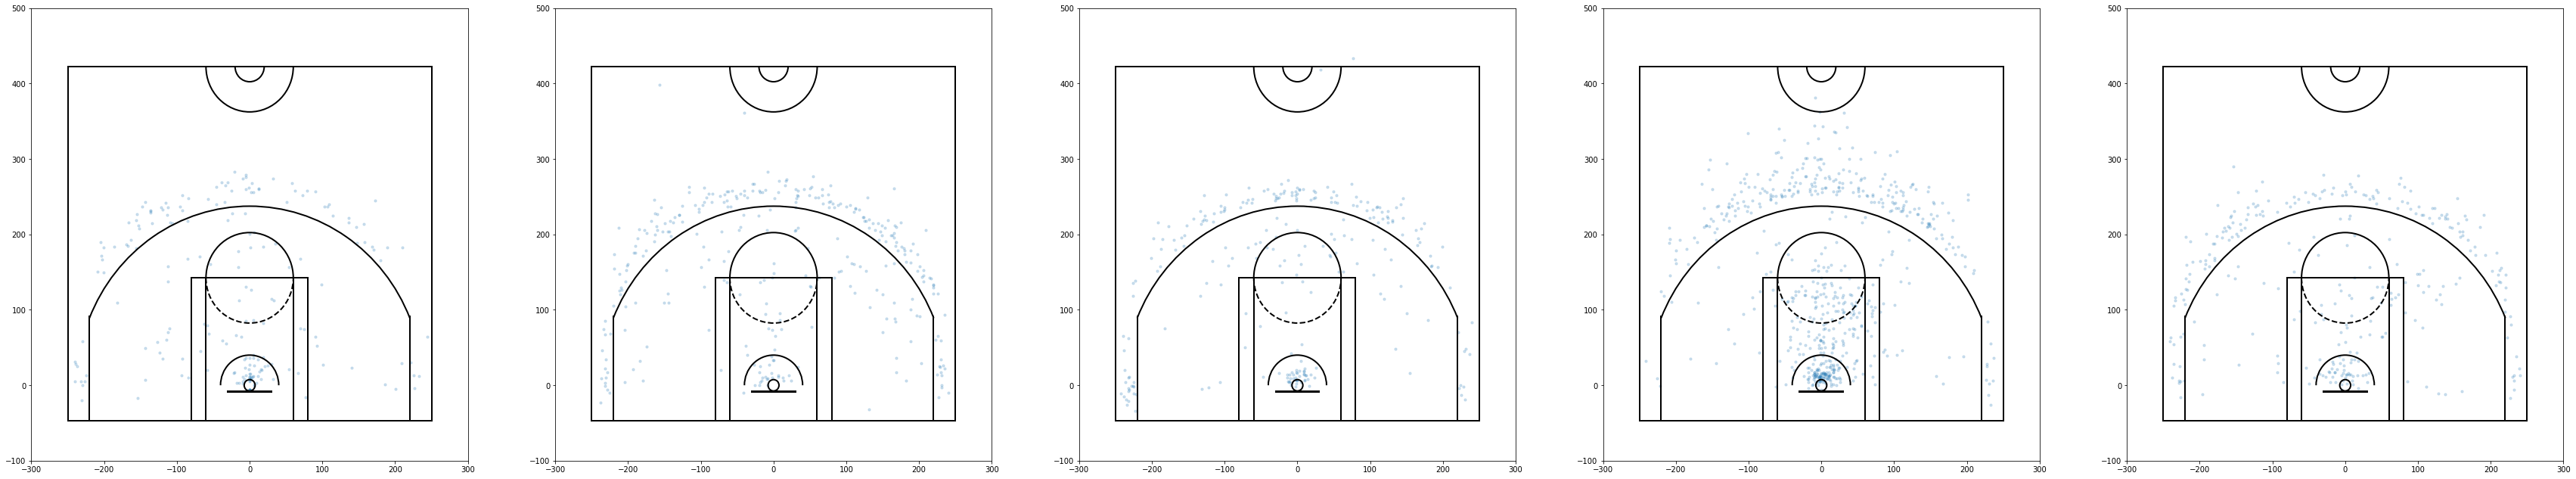

2


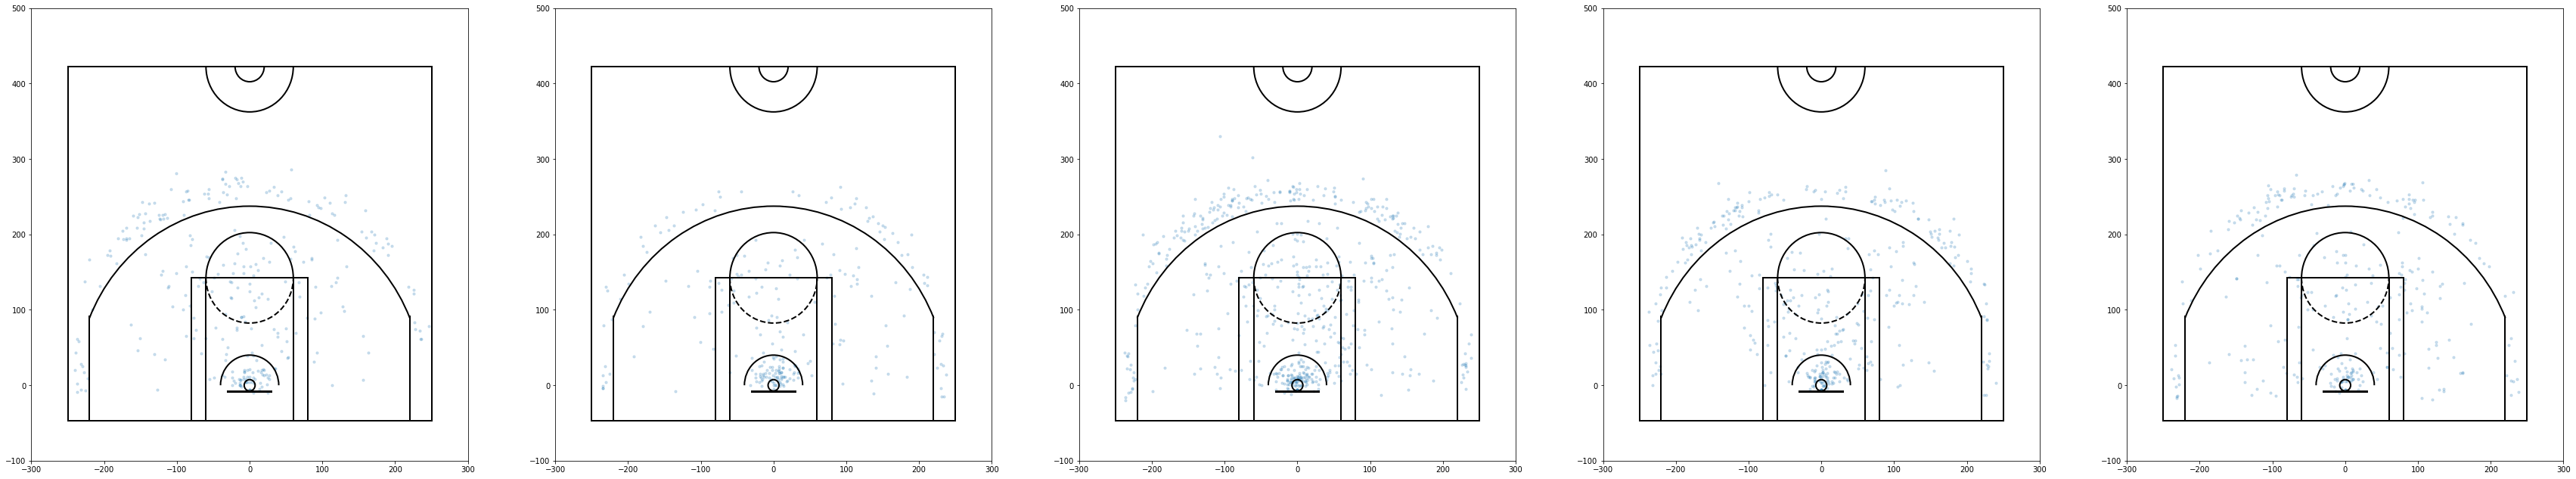

3


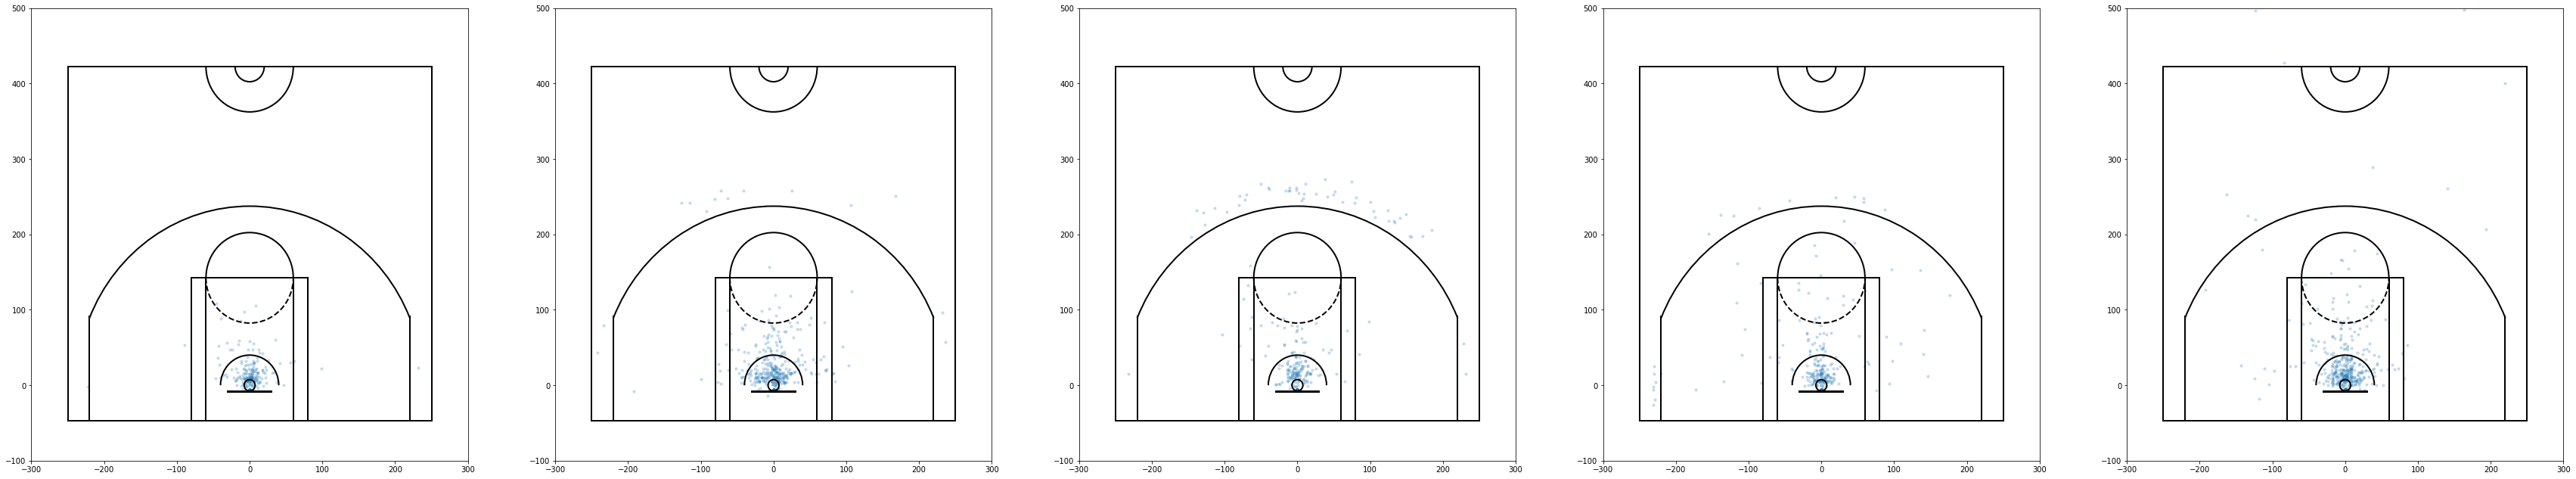

4


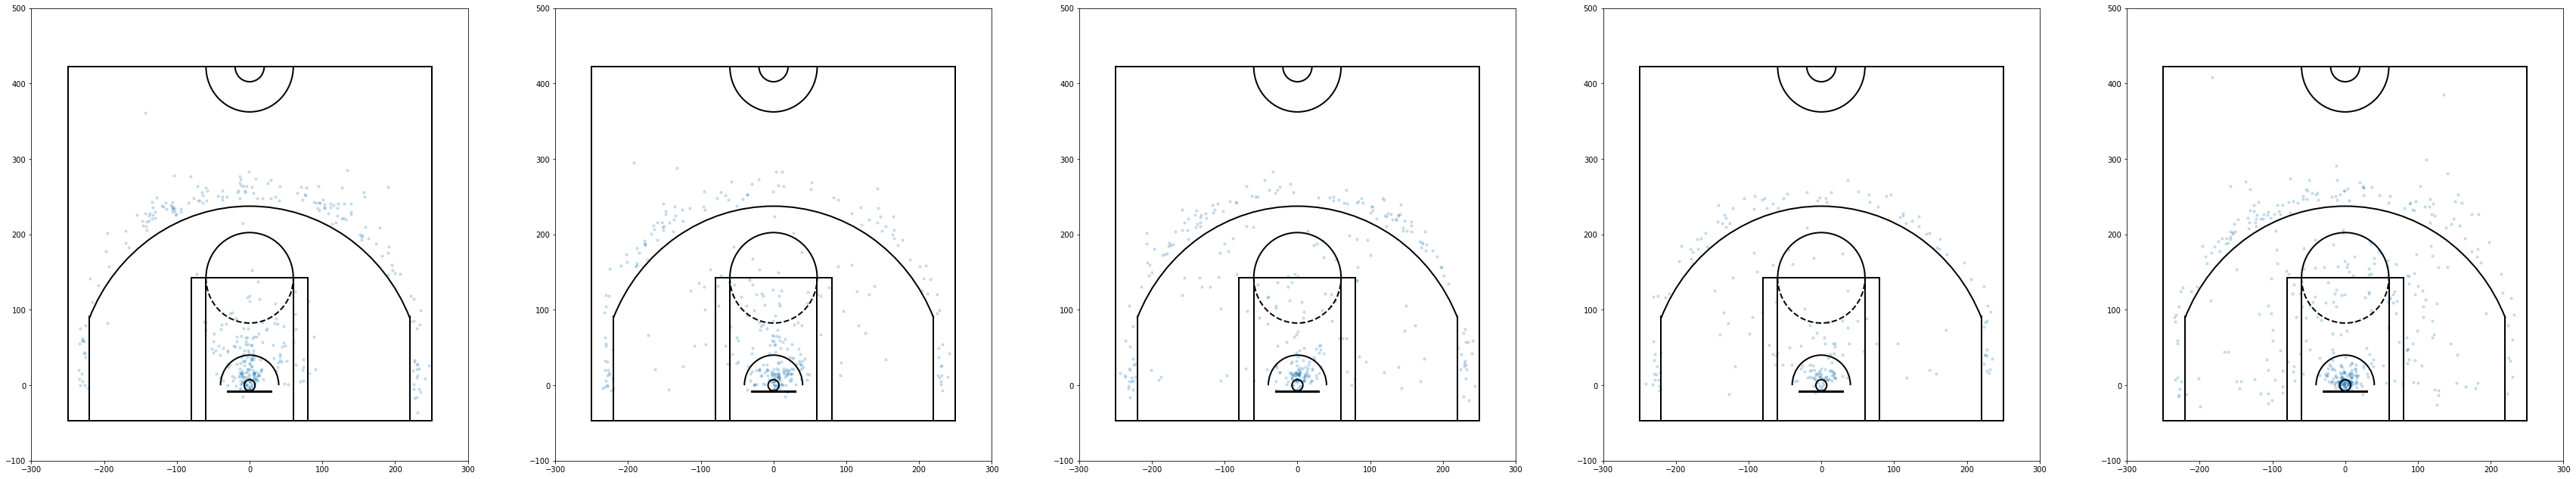

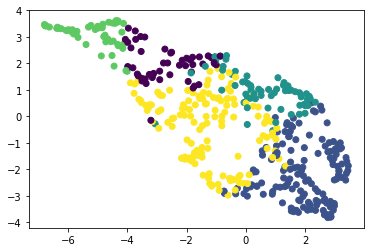

In [173]:
get_plots_using_new_clusters(rn)

In [186]:
clusters = get_players_from_each_cluster(rn)
for index, cluster in enumerate(clusters):
    print('CLUSTER ', index)
    print('\n\n\n\n\n\n')
    for player in cluster:
        print(player)

CLUSTER  0







Bruce Brown
Justise Winslow
Bam Adebayo
Dejounte Murray
Chandler Hutchison
Shaquille Harrison
Hassan Whiteside
Skal Labissiere
Terance Mann
Christian Wood
Domantas Sabonis
T.J. McConnell
Willie Cauley-Stein
Kevon Looney
Marquese Chriss
Elfrid Payton
Taj Gibson
Ed Davis
Tristan Thompson
Chimezie Metu
Rui Hachimura
Noah Vonleh
Jonas Valanciunas
Ja Morant
Brandon Clarke
Kyle Anderson
TJ Leaf
Brian Bowen II
Alize Johnson
Daniel Theis
Javonte Green
Alex Len
DeAndre' Bembry
JaKarr Sampson
Edmond Sumner
Marvin Bagley III
Nicolas Claxton
Yuta Watanabe
Nerlens Noel
Anzejs Pasecniks
Boban Marjanovic
Khem Birch
Dean Wade
Udonis Haslem
Romeo Langford
Zylan Cheatham
Dante Exum
Amile Jefferson
Jalen McDaniels
Deandre Ayton
Josh Magette
CLUSTER  1







Tony Snell
Markieff Morris
Reggie Jackson
Langston Galloway
Luke Kennard
Evan Fournier
D.J. Augustin
Terrence Ross
Matisse Thybulle
Furkan Korkmaz
Mike Scott
Shake Milton
Goran Dragic
Tyler Herro
Kelly Olynyk
Duncan Robinson
Trey Ly